<div dir=ltr align=center>In the name of God</div>
<br>
<font size=6><div dir=ltr align=center>
<font size=5>
Intelligent Analysis of
Biomedical Images
<br>
<font size=4>
sharif university of technology, CE department
</font>
<br>
<font size=3>
Dr. Rohban

Designer: Reza Vahidimajd
</font>
<br>
<br>
<font size=6>
Homework 5
</font><br>
<font size=4>


#Vision Transformer for Brain Tumor Image Classification

In this notebook, we delve into the robust capabilities of Vision Transformers (ViT) for tackling the intricate task of image classification using the Brain Tumor dataset. While traditional Convolutional Neural Networks (CNNs) have long been the standard architecture for image-related tasks, ViT introduces a novel approach by leveraging self-attention mechanisms inspired by the Transformer architecture originally developed for natural language processing.

The Brain Tumor dataset utilized here comprises a collection of brain MRI scans, each meticulously categorized into four distinct classes. Our objective is to design and train a custom ViT model that can accurately classify these MRI scans based on their visual features, demonstrating the effectiveness of Vision Transformers in medical image analysis.

#Vision Transformer

A Vision Transformer (ViT) is a cutting-edge deep learning architecture that adapts the Transformer model—originally designed for sequential data like text—to process image data effectively. This innovative approach begins by dividing an input image into fixed-size patches, which are then linearly embedded into vector representations. These embedded vectors are treated as a sequence and fed into Transformer layers, enabling the ViT to capture both local and global dependencies within the image. By leveraging self-attention mechanisms, Vision Transformers can model complex relationships and patterns, making them highly effective for various image analysis tasks.

#Brain Tumor Dataset

The Brain Tumor dataset is a crucial collection of brain MRI scans acquired from patients with and without brain tumors. Each image in the dataset presents a unique challenge due to varying sizes, resolutions, and contrasts. Our goal is to leverage the ViT architecture to develop a robust classification model that can accurately identify the presence of brain tumors in these MRI scans.

# 1. Libabries and Files

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!gdown 1nSwAxOS2bCn9m7cXnA-z9-0ADhb4CBuv
!unzip Brain_tumor.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [ ]:
%ls

Brain_tumor.zip  sample_data/  Testing/  Training/


In [ ]:
%ls Training

glioma/  meningioma/  notumor/  pituitary/


In [ ]:
%ls Testing

glioma/  meningioma/  notumor/  pituitary/


# 2. Hyperparameters

In [ ]:
# Hyperparameters and constants
learning_rate = 0.0001
weight_decay = 0.0001
num_classes = 4
batch_size = 32
num_epochs = 20
class_name = ['glioma', 'meningioma', 'notumor', 'pituitary']

image_size = 256
patch_size = 16
in_channels = 1    # number of channels in input images
embed_dim = 64     # projection dimension (d)
num_heads = 4
num_layers = 12    # e.g., 12 for ViT-B/16 in the original paper
mlp_ratio = 4      # ratio in the MLP (4 is typical in ViT)
dropout_rate = 0.0 # dropout rate
attn_dropout_rate = 0.0

# The number of patches
num_patches = (image_size // patch_size) * (image_size // patch_size)

train_data_path = '/content/Training'
test_data_path = '/content/Testing'

# 3. Dataset

In [ ]:
# Transforms
train_transforms = transforms.Compose([
    ##############################################
    #################### TODO ####################
    ##############################################
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Grayscale(num_output_channels=1),  # Ensure single channel
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transforms = transforms.Compose([
    ##############################################
    #################### TODO ####################
    ##############################################
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [ ]:
# Load datasets
full_train_dataset = datasets.ImageFolder(train_data_path, transform=train_transforms)
val_len = int(0.2 * len(full_train_dataset))
train_len = len(full_train_dataset) - val_len
train_dataset, val_dataset = random_split(full_train_dataset, [train_len, val_len])

test_dataset = datasets.ImageFolder(test_data_path, transform=val_test_transforms)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# 4. Model

In [ ]:
class PatchEmbedding(nn.Module):
    """
    Splits an image into patches and embeds them into a vector space.
    """
    def __init__(self, img_size=256, patch_size=16, in_chans=1, embed_dim=768):
        """
        Initializes the PatchEmbedding module.

        Args:
            img_size (int): The size of the input image (assumed square).
            patch_size (int): The size of each square patch.
            in_chans (int): Number of input channels in the image.
            embed_dim (int): Dimension of the embedding space.

        TODO:
            - Assert that img_size is divisible by patch_size.
            - Calculate the number of patches.
            - Initialize the projection layer (e.g., nn.Conv2d) to embed patches.
        """
        super(PatchEmbedding, self).__init__()
        # TODO: Implement the initialization logic
        assert img_size % patch_size == 0, "Image size must be divisible by patch size"
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        """
        Forward pass of the PatchEmbedding module.

        Args:
            x (Tensor): Input tensor of shape (batch_size, in_chans, img_size, img_size).

        Returns:
            Tensor: Embedded patches of shape (batch_size, num_patches, embed_dim).

        TODO:
            - Apply the projection layer to the input.
            - Flatten the spatial dimensions to obtain patches.
            - Transpose the tensor to match the desired output shape.
        """
        # TODO: Implement the forward pass
        # pass
        x = self.proj(x)  # (B, E, H/P, W/P)
        x = x.flatten(2).transpose(1, 2)  # (B, num_patches, E)
        return x

with torch.no_grad():
  patch_embedding=PatchEmbedding().cpu().eval()
  patch_embedding_shape=patch_embedding(torch.randn(1,1,256,256)).shape
  print(patch_embedding,patch_embedding_shape)

PatchEmbedding(
  (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
) torch.Size([1, 256, 768])


PatchEmbedding(
  (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
) torch.Size([1, 256, 768])


In [ ]:
class TransformerEncoderLayer(nn.Module):
    """
    Single Transformer Encoder Layer consisting of multi-head self-attention and MLP.
    """
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout_rate=0.1, attn_dropout_rate=0.1):
        """
        Initializes the TransformerEncoderLayer.

        Args:
            embed_dim (int): Dimension of the embedding space.
            num_heads (int): Number of attention heads.
            mlp_ratio (float): Ratio of the hidden dimension in the MLP relative to embed_dim.
            dropout_rate (float): Dropout rate after MLP.
            attn_dropout_rate (float): Dropout rate in the attention layer.

        TODO:
            - Initialize layer normalization layers.
            - Initialize multi-head attention layer.
            - Initialize dropout layers.
            - Initialize MLP (feed-forward) layers.
        """
        super(TransformerEncoderLayer, self).__init__()
        # TODO: Implement the initialization logic
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=attn_dropout_rate, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim),
            nn.Dropout(dropout_rate)
        )

    def forward(self, x, return_attn=False):
        """
        Forward pass of the TransformerEncoderLayer.

        Args:
            x (Tensor): Input tensor of shape (batch_size, num_tokens, embed_dim).
            return_attn (bool): Whether to return attention weights.

        Returns:
            Tuple[Tensor, Optional[Tensor]]:
                - Output tensor of shape (batch_size, num_tokens, embed_dim).
                - Attention weights if return_attn is True, else None.

        TODO:
            - Apply layer normalization to the input.
            - Perform multi-head self-attention.
            - Add residual connection and apply dropout.
            - Apply second layer normalization.
            - Pass through the MLP.
            - Add residual connection and apply dropout.
            - Return attention weights if requested.
        """
        # TODO: Implement the forward pass
        # pass
        res = x
        x = self.norm1(x)
        x, attn_weights = self.attn(x, x, x)
        x = self.dropout1(x)
        x += res

        res = x
        x = self.norm2(x)
        x = self.mlp(x)
        x += res

        return (x, attn_weights) if return_attn else (x, None)

with torch.no_grad():
  transformer_encoder_layer = TransformerEncoderLayer(embed_dim, num_heads).cpu().eval()
  transformer_encoder_layer_shape = transformer_encoder_layer(torch.randn(1, num_patches, embed_dim))[0].shape
  print(transformer_encoder_layer, transformer_encoder_layer_shape)

TransformerEncoderLayer(
  (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (dropout1): Dropout(p=0.1, inplace=False)
  (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): Dropout(p=0.1, inplace=False)
  )
) torch.Size([1, 256, 64])


TransformerEncoderLayer(
  (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (dropout1): Dropout(p=0.1, inplace=False)
  (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): Dropout(p=0.1, inplace=False)
  )
) torch.Size([1, 256, 64])


In [ ]:
class TransformerEncoder(nn.Module):
    """
    Stacks multiple Transformer Encoder Layers to form the Transformer Encoder.
    """
    def __init__(self, num_layers, embed_dim, num_heads, mlp_ratio, dropout_rate, attn_dropout_rate):
        """
        Initializes the TransformerEncoder.

        Args:
            num_layers (int): Number of TransformerEncoderLayer instances to stack.
            embed_dim (int): Dimension of the embedding space.
            num_heads (int): Number of attention heads in each layer.
            mlp_ratio (float): Ratio of the hidden dimension in the MLP relative to embed_dim.
            dropout_rate (float): Dropout rate after MLP.
            attn_dropout_rate (float): Dropout rate in the attention layers.

        TODO:
            - Create a ModuleList containing the specified number of TransformerEncoderLayer instances.
            - Initialize the final layer normalization.
        """
        super(TransformerEncoder, self).__init__()
        # TODO: Implement the initialization logic
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(embed_dim, num_heads, mlp_ratio, dropout_rate, attn_dropout_rate)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(embed_dim) # Initialize the final layer normalization.

    def forward(self, x, return_attn=False):
        """
        Forward pass of the TransformerEncoder.

        Args:
            x (Tensor): Input tensor of shape (batch_size, num_tokens, embed_dim).
            return_attn (bool): Whether to return attention weights from all layers.

        Returns:
            Tuple[Tensor, Optional[List[Tensor]]]:
                - Output tensor of shape (batch_size, num_tokens, embed_dim).
                - List of attention weights from each layer if return_attn is True, else None.

        TODO:
            - Iterate through each TransformerEncoderLayer, passing the input tensor.
            - Collect attention weights if return_attn is True.
            - Apply final layer normalization.
            - Return the output and attention weights as required.
        """
        # TODO: Implement the forward pass
        # pass
        attn_maps = []
        for layer in self.layers:
            x, attn = layer(x, return_attn=return_attn)
            if return_attn and attn is not None:
                attn_maps.append(attn)
        x = self.norm(x) # Apply final layer normalization.
        return (x, attn_maps) if return_attn else (x, None)

with torch.no_grad():
  transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, mlp_ratio, dropout_rate, attn_dropout_rate).cpu().eval()
  transformer_encoder_shape = transformer_encoder(torch.randn(1, num_patches, embed_dim))[0].shape
  print(transformer_encoder, transformer_encoder_shape)

TransformerEncoder(
  (layers): ModuleList(
    (0-11): 12 x TransformerEncoderLayer(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (dropout1): Dropout(p=0.0, inplace=False)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=256, out_features=64, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
) torch.Size([1, 256, 64])


TransformerEncoder(
  (layers): ModuleList(
    (0-11): 12 x TransformerEncoderLayer(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (dropout1): Dropout(p=0.0, inplace=False)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=256, out_features=64, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
) torch.Size([1, 256, 64])


In [ ]:
class VisionTransformer(nn.Module):
    """
    Vision Transformer (ViT) model for image classification.
    """
    def __init__(self, img_size, patch_size, in_chans, num_classes,
                 embed_dim, num_heads, mlp_ratio, num_layers,
                 dropout_rate, attn_dropout_rate):
        """
        Initializes the VisionTransformer.

        Args:
            img_size (int): Size of the input image (assumed square).
            patch_size (int): Size of each square patch.
            in_chans (int): Number of input channels in the image.
            num_classes (int): Number of output classes for classification.
            embed_dim (int): Dimension of the embedding space.
            num_heads (int): Number of attention heads in each Transformer layer.
            mlp_ratio (float): Ratio of the hidden dimension in the MLP relative to embed_dim.
            num_layers (int): Number of TransformerEncoderLayer instances.
            dropout_rate (float): Dropout rate after embeddings and MLP.
            attn_dropout_rate (float): Dropout rate in the attention layers.

        TODO:
            - Initialize PatchEmbedding.
            - Initialize class token and positional embeddings.
            - Initialize dropout for positional embeddings.
            - Initialize TransformerEncoder.
            - Initialize the classification head (LayerNorm and Linear layer).
            - Initialize model weights.
        """
        super(VisionTransformer, self).__init__()
        # TODO: Implement the initialization logic
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) # Initialize class token
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim)) # Initialize positional embeddings.
        self.pos_drop = nn.Dropout(dropout_rate)

        self.encoder = TransformerEncoder(num_layers, embed_dim, num_heads, mlp_ratio, dropout_rate, attn_dropout_rate)
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        self._init_weights()

    def _init_weights(self):
        """
        Initializes the weights of the model.

        TODO:
            - Initialize positional embeddings and class token with truncated normal distribution.
            - Apply weight initialization to all modules.
        """
        # TODO: Implement weight initialization
        # pass
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        self.apply(self._init_module_weights)

    def _init_module_weights(self, module):
        """
        Initializes weights for individual modules.

        Args:
            module (nn.Module): The module to initialize.

        TODO:
            - Initialize Linear layers with truncated normal for weights and zeros for biases.
            - Initialize LayerNorm layers with ones for weights and zeros for biases.
            - Initialize Conv2d layers with Kaiming normal for weights and zeros for biases.
        """
        # TODO: Implement module-specific weight initialization
        # pass
        if isinstance(module, nn.Linear):
            nn.init.trunc_normal_(module.weight, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            nn.init.zeros_(module.bias)
            nn.init.ones_(module.weight)
        elif isinstance(module, nn.Conv2d):
            # fan_in = module.in_channels * module.kernel_size[0] * module.kernel_size[1]
            # nn.init.trunc_normal_(module.weight, std=math.sqrt(1.0 / fan_in))
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')

            if module.bias is not None:
                nn.init.zeros_(module.bias)

    def forward(self, x, return_attn=False):
        """
        Forward pass of the VisionTransformer.

        Args:
            x (Tensor): Input tensor of shape (batch_size, in_chans, img_size, img_size).
            return_attn (bool): Whether to return attention maps from the Transformer.

        Returns:
            Tuple[Tensor, Optional[List[Tensor]]]:
                - Logits tensor of shape (batch_size, num_classes).
                - List of attention maps from each Transformer layer if return_attn is True, else None.

        TODO:
            - Embed the input patches using PatchEmbedding.
            - Concatenate the class token to the patch embeddings.
            - Add positional embeddings to the combined embeddings.
            - Apply dropout to the embeddings.
            - Pass the embeddings through the TransformerEncoder.
            - Extract the class token's representation.
            - Pass the class token through the classification head to obtain logits.
            - Return logits and attention maps as required.
        """
        # TODO: Implement the forward pass
        # pass
        B = x.shape[0]
        x = self.patch_embed(x)  # (B, num_patches, embed_dim)

        cls_tokens = self.cls_token.expand(B, -1, -1) # (B, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1) # (B, num_patches + 1, embed_dim)
        x += self.pos_embed
        x = self.pos_drop(x)

        x, attn_maps = self.encoder(x, return_attn=return_attn)
        x = self.norm(x)

        logits = self.head(x[:, 0]) # cls_token_final = x[:, 0]
        return logits, attn_maps

with torch.no_grad():
  vision_transformer = VisionTransformer(
    img_size=image_size,
    patch_size=patch_size,
    in_chans=in_channels,
    num_classes=num_classes,
    embed_dim=embed_dim,
    num_heads=num_heads,
    mlp_ratio=mlp_ratio,
    num_layers=num_layers,
    dropout_rate=dropout_rate,
    attn_dropout_rate=attn_dropout_rate
    ).cpu().eval()
  vision_transformer_shape = vision_transformer(torch.randn(1, 1, 256, 256))[0].shape
  print(vision_transformer, vision_transformer_shape)

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(1, 64, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (dropout1): Dropout(p=0.0, inplace=False)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=64, out_features=256, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=256, out_features=64, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (norm): Laye

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.1, inplace=False)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (n

In [ ]:
# Setup the device, model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisionTransformer(
    img_size=image_size,
    patch_size=patch_size,
    in_chans=in_channels,
    num_classes=num_classes,
    embed_dim=embed_dim,
    num_heads=num_heads,
    mlp_ratio=mlp_ratio,
    num_layers=num_layers,
    dropout_rate=dropout_rate,
    attn_dropout_rate=attn_dropout_rate
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# 5. Training

In [ ]:
# Initialize lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
best_val_acc = 0.0
best_model_path = 'best_vit_model.pth'

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        ##############################################
        #################### TODO ####################
        ##############################################
        optimizer.zero_grad()
        outputs, _ = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_acc = train_correct / total_train
    train_loss = train_loss / total_train

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            ##############################################
            #################### TODO ####################
            ##############################################
            outputs, _ = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_acc = val_correct / total_val
    val_loss = val_loss / total_val

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Append metrics to lists
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)

Epoch [1/20], Train Loss: 1.1409, Train Acc: 0.5243, Val Loss: 1.0166, Val Acc: 0.6182
Epoch [2/20], Train Loss: 0.9586, Train Acc: 0.6363, Val Loss: 0.8720, Val Acc: 0.6708
Epoch [3/20], Train Loss: 0.8683, Train Acc: 0.6687, Val Loss: 0.8514, Val Acc: 0.6926
Epoch [4/20], Train Loss: 0.7836, Train Acc: 0.7050, Val Loss: 0.6951, Val Acc: 0.7504
Epoch [5/20], Train Loss: 0.6996, Train Acc: 0.7333, Val Loss: 0.6446, Val Acc: 0.7653
Epoch [6/20], Train Loss: 0.6514, Train Acc: 0.7523, Val Loss: 0.7075, Val Acc: 0.7391
Epoch [7/20], Train Loss: 0.6094, Train Acc: 0.7702, Val Loss: 0.7526, Val Acc: 0.7102
Epoch [8/20], Train Loss: 0.5651, Train Acc: 0.7880, Val Loss: 0.5404, Val Acc: 0.8082
Epoch [9/20], Train Loss: 0.5276, Train Acc: 0.8050, Val Loss: 0.5175, Val Acc: 0.8152
Epoch [10/20], Train Loss: 0.5147, Train Acc: 0.8033, Val Loss: 0.4636, Val Acc: 0.8371
Epoch [11/20], Train Loss: 0.4908, Train Acc: 0.8182, Val Loss: 0.6276, Val Acc: 0.7644
Epoch [12/20], Train Loss: 0.4676, Train 

# 6. Evaluation

In [ ]:
# Load best model
model.load_state_dict(torch.load(best_model_path))

# Test evaluation
model.eval()
test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        ##############################################
        #################### TODO ####################
        ##############################################
        outputs, _ = model(images) # [B, 4], _
        _, predicted = torch.max(outputs, 1) # [B, 1]
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = test_correct / test_total

print(f"Test Accuracy: {test_acc:.4f}")

<ipython-input-18-02a49df3a34f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Test Accuracy: 0.8299


# 7. Loss Plots and Confusion Matrix

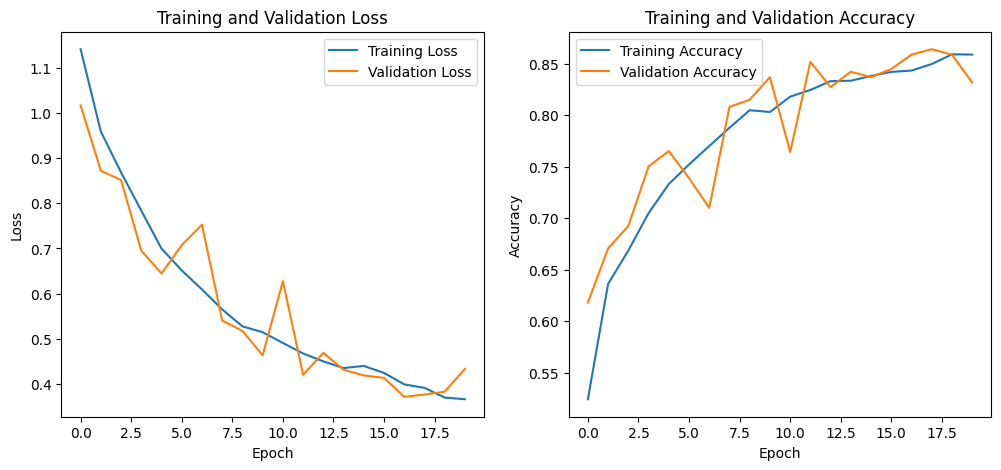

In [ ]:
# Plotting Training and Validation Loss

##############################################
#################### TODO ####################
##############################################
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting Training and Validation Accuracy

##############################################
#################### TODO ####################
##############################################
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

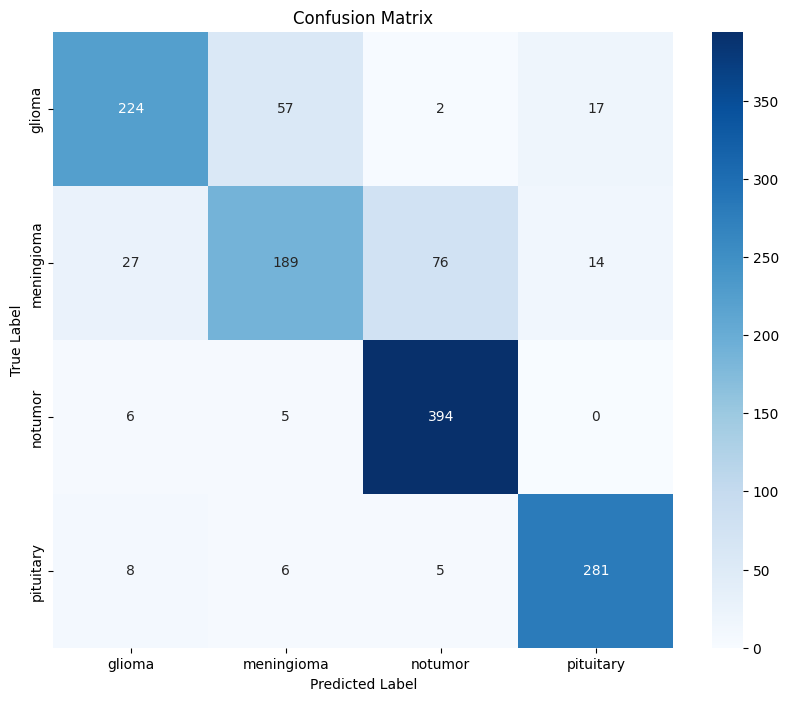

In [ ]:
# Collect all predictions and true labels for the test set
all_preds = []
all_labels = []

# Load best model
# model.load_state_dict(torch.load(best_model_path))
model.load_state_dict(torch.load(best_model_path, weights_only=True)) # does not have FutureWarning
# Test evaluation
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        ##############################################
        #################### TODO ####################
        ##############################################
        outputs, _ = model(images) # [B, 4], _
        _, predicted = torch.max(outputs, 1) # [B, 1]
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix for test set
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix

##############################################
#################### TODO ####################
##############################################
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_name, yticklabels=class_name)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 8. Visualize Attention of the Model

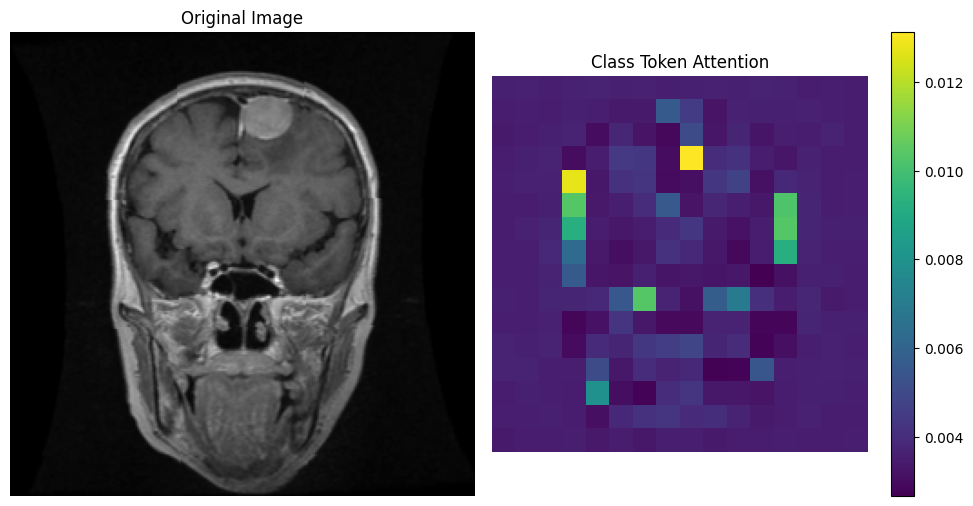

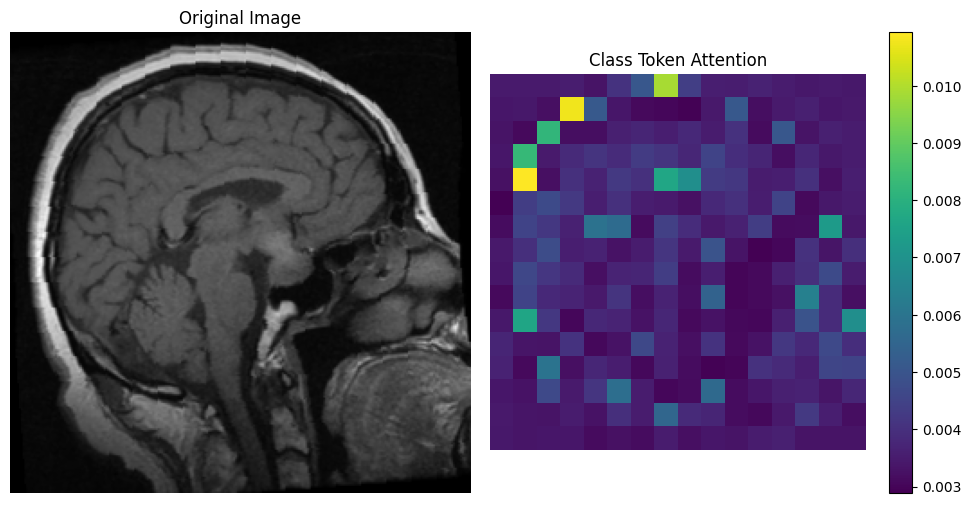

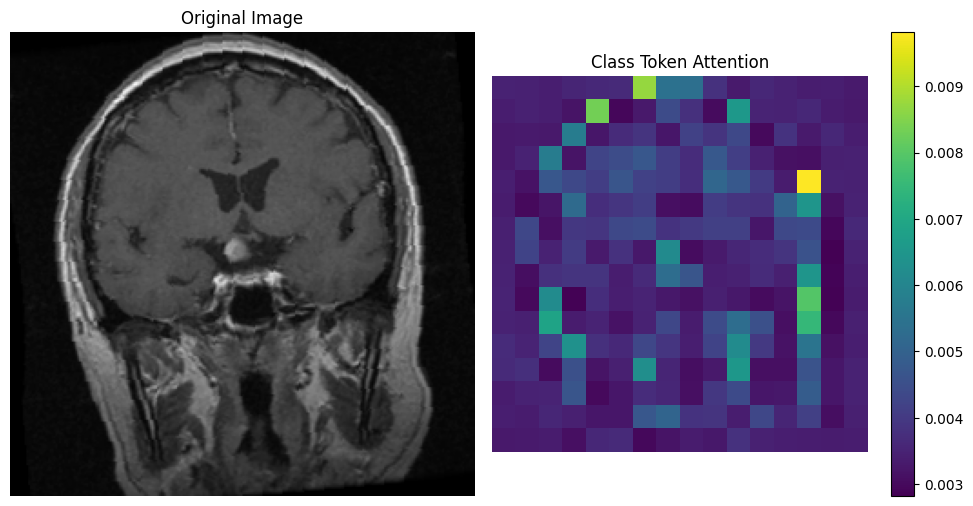

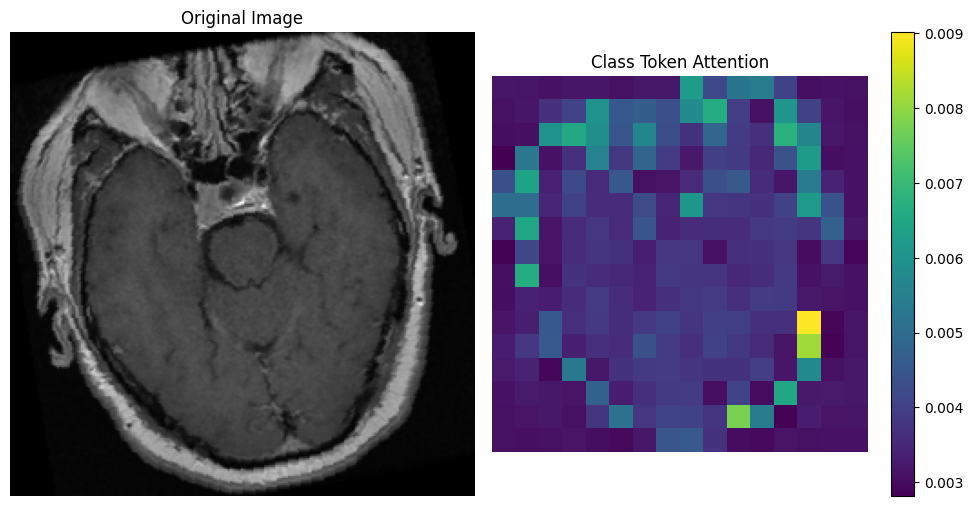

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()
with torch.no_grad():
    num = 0
    for images, labels in val_loader:
        images = images.to(device)

        logits, attn_maps = model(images, return_attn=True)
        # attn_maps.size() list of Pytorch Tensors [12, torch.Size([32, 257, 257])]

        ##################################################
        ####################### TODO #####################
        # Compute the 2d attention map for 4 different   #
        # images showing the attention of the model      #
        # on each patch of the image                     #
        ##################################################
        ##################################################
        if num >= 4:
            break
        num += 1

        # attn_map_2d = ...

        # Method1: just use the last attention layer (can also use other layers for example layer 0 for further analysis)
        # attn_map_2d = attn_maps[-1][0, 0, 1:].reshape(16, 16).cpu().numpy()

        # Method2: use the mean attention layer across 12 layers
        attn_maps = torch.stack(attn_maps)  # (num_layers, batch, seq_len, seq_len)
        # print(attn_maps.size()) # torch.Size([12, 32, 257, 257])
        # Take first image in batch
        batch_idx = 0
        attn_maps = attn_maps[:, batch_idx]  # (num_layers, seq_len, seq_len)
        # Average across layers and heads
        cls_attentions = attn_maps[:, 0, 1:].mean(dim=0)  # (num_patches, )
        # Reshape to 2D
        patch_per_side = image_size // patch_size
        attn_map_2d = cls_attentions.reshape(patch_per_side, patch_per_side).cpu().numpy() # (16, 16)


        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        img_np = images[0].detach().cpu().numpy().transpose(1,2,0)
        img_np = np.squeeze(img_np)
        axes[0].imshow(img_np, cmap='gray')
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        im = axes[1].imshow(attn_map_2d, cmap='viridis')
        axes[1].set_title('Class Token Attention')
        axes[1].axis('off')

        fig.colorbar(im, ax=axes[1])
        plt.tight_layout()
        plt.show()